## prophet

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import itertools
from scipy import stats

# JSON API
import requests
import json

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from fbprophet import Prophet

%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from acquire import tsa_acquire_all
from acquire import peekatdata
from acquire import missing_values_col
from prepare import data_prepped
from prepare import missing_values_col

### Using stores customer data

In [2]:
df = data_prepped(tsa_acquire_all())

Checking for existing items.csv...
Reading items from local csv...

Checking for existing stores.csv...
Reading stores from local csv...

Checking for existing sales.csv...
Reading sales from local csv...

Writing final df.csv...

Finished writing final df.csv.  Final df done.

HEADS UP: finished all tsa acquire.  Full Stop!

Final raw df now ready to begin data preparations.



Please wait for df preparations to process...

Date/time conversion in process...
Additional data parts are being added...
Executing "improve_sales_data" function...
Renaming "sale_amount" field to "quantity"...
New index is being set with the date/time field...

New prepped df is ready for use.



In [3]:
df.tail(3)

,item_id,quantity,sale_date,sale_id,store_id,item_brand,item_name,item_price,item_upc12,item_upc14,...,store_city,store_state,store_zipcode,year,quarter,month,day,weekday,is_weekend,sale_total
sale_date_index_col,,,,,,,,,,,,,,,,,,,,,
2017-12-29,50,74.0,2017-12-29,912998,10,Choice,Choice Organic Teas Black Tea Classic Black - ...,5.2,47445919221,47445919221,...,San Antonio,TX,78231,2017,4,12,29,Fri,False,384.8
2017-12-30,50,62.0,2017-12-30,912999,10,Choice,Choice Organic Teas Black Tea Classic Black - ...,5.2,47445919221,47445919221,...,San Antonio,TX,78231,2017,4,12,30,Sat,True,322.4
2017-12-31,50,82.0,2017-12-31,913000,10,Choice,Choice Organic Teas Black Tea Classic Black - ...,5.2,47445919221,47445919221,...,San Antonio,TX,78231,2017,4,12,31,Sun,True,426.4


In [4]:
missing_values_col(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
item_id,0,0.0,0,0.0,0,0.0
quantity,0,0.0,0,0.0,0,0.0
sale_date,0,0.0,0,0.0,0,0.0
sale_id,0,0.0,0,0.0,0,0.0
store_id,0,0.0,0,0.0,0,0.0
item_brand,0,0.0,0,0.0,0,0.0
item_name,0,0.0,0,0.0,0,0.0
item_price,0,0.0,0,0.0,0,0.0
item_upc12,0,0.0,0,0.0,0,0.0
item_upc14,0,0.0,0,0.0,0,0.0


In [5]:
peekatdata(df)


 
 SHAPE:
(913000, 21)

 
 COLS:
Index(['item_id', 'quantity', 'sale_date', 'sale_id', 'store_id', 'item_brand',
       'item_name', 'item_price', 'item_upc12', 'item_upc14', 'store_address',
       'store_city', 'store_state', 'store_zipcode', 'year', 'quarter',
       'month', 'day', 'weekday', 'is_weekend', 'sale_total'],
      dtype='object')

 
 INFO:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 21 columns):
item_id          913000 non-null int64
quantity         913000 non-null float64
sale_date        913000 non-null datetime64[ns]
sale_id          913000 non-null int64
store_id         913000 non-null int64
item_brand       913000 non-null object
item_name        913000 non-null object
item_price       913000 non-null float64
item_upc12       913000 non-null int64
item_upc14       913000 non-null int64
store_address    913000 non-null object
store_city       913000 non-null object
store_state      913000 non-

### Predict 2018 total monthly sales for store 1 by creating a model using prophet

We are interested in forecasting total sales at store id 1.


Prophet only takes data as a dataframe with a ds (datestamp) and y (value we want to forecast) column. So first, we convert the dataframe to the appropriate format.


- Convert Date to a datetime format using the to_datetime() function.


- Aggregate the y value, the measure as needed and and keep only that column and the datestamp.


- Set Date as the index so we can use the resample() and mean() function to find the daily average price. Reset the index and drop any missing values from the dataset.

In [6]:
df1 = df[df['store_id'] == 1]
df1 = df1[df1['item_brand'] == 'Kelloggs']

In [7]:
df1.shape

(1826, 21)

In [8]:
df1.tail(5)

,item_id,quantity,sale_date,sale_id,store_id,item_brand,item_name,item_price,item_upc12,item_upc14,...,store_city,store_state,store_zipcode,year,quarter,month,day,weekday,is_weekend,sale_total
sale_date_index_col,,,,,,,,,,,,,,,,,,,,,
2017-12-27,45,65.0,2017-12-27,805262,1,Kelloggs,Kelloggs Disney Pixar Cars 2 Cereal,4.4,38000542237,38000542237,...,San Antonio,TX,78253,2017,4,12,27,Wed,False,286.0
2017-12-28,45,54.0,2017-12-28,805263,1,Kelloggs,Kelloggs Disney Pixar Cars 2 Cereal,4.4,38000542237,38000542237,...,San Antonio,TX,78253,2017,4,12,28,Thu,False,237.6
2017-12-29,45,77.0,2017-12-29,805264,1,Kelloggs,Kelloggs Disney Pixar Cars 2 Cereal,4.4,38000542237,38000542237,...,San Antonio,TX,78253,2017,4,12,29,Fri,False,338.8
2017-12-30,45,63.0,2017-12-30,805265,1,Kelloggs,Kelloggs Disney Pixar Cars 2 Cereal,4.4,38000542237,38000542237,...,San Antonio,TX,78253,2017,4,12,30,Sat,True,277.2
2017-12-31,45,73.0,2017-12-31,805266,1,Kelloggs,Kelloggs Disney Pixar Cars 2 Cereal,4.4,38000542237,38000542237,...,San Antonio,TX,78253,2017,4,12,31,Sun,True,321.2


In [9]:
df1['y'] = df1.sale_total * df1.item_price
df1['ds'] = pd.to_datetime(df1.sale_date)
#df1 = df1.groupby(['ds'])['y'].sum().reset_index()
df1 = df1.groupby(['ds']).y.sum().asfreq('MS').reset_index()

#df2 = df.groupby('sale_date').sale_amount.sum().asfreq('12H')

In [59]:
df1.shape

(60, 2)

In [60]:
df1.head()

,ds,y
0,2013-01-01,716.32
1,2013-02-01,890.56
2,2013-03-01,1239.04
3,2013-04-01,987.36
4,2013-05-01,1355.20


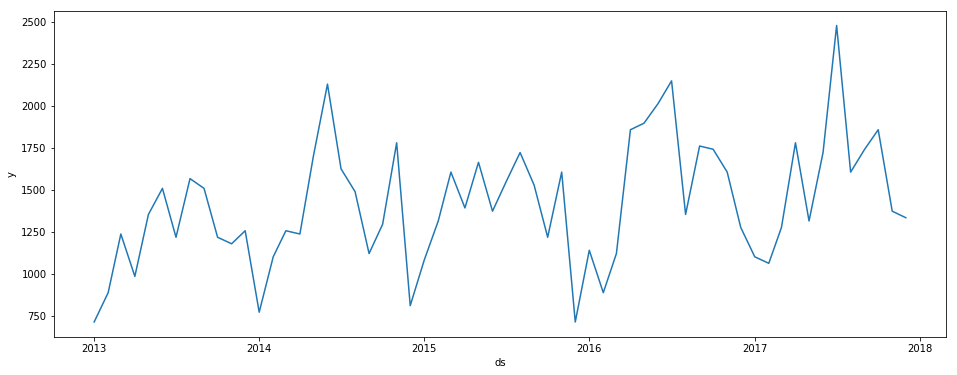

In [11]:
# sns.scatterplot(d_df.ds, d_df.y)
# df = d_df.set_index('ds')
plt.figure(figsize=(16,6))
sns.lineplot(df1.ds,df1.y)

## Model
### Create an instance of the Prophet class and then fit our dataframe to it

In [12]:
m = Prophet()
m.fit(df1)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Create a "future" dataframe
- Use make_future_dataframe() to create a dataframe with the dates for which we want a prediction.
- Then specify the number of days to forecast using the periods parameter.

In [13]:
# future = m.make_future_dataframe(periods=365)

future = m.make_future_dataframe(periods=12, freq='M')
print(future.head())
print(future.tail())
print(df1.tail())

          ds
0 2013-01-01
1 2013-02-01
2 2013-03-01
3 2013-04-01
4 2013-05-01
           ds
67 2018-07-31
68 2018-08-31
69 2018-09-30
70 2018-10-31
71 2018-11-30
           ds        y
55 2017-08-01  1606.88
56 2017-09-01  1742.40
57 2017-10-01  1858.56
58 2017-11-01  1374.56
59 2017-12-01  1335.84


In [14]:
print('future range, min and max')
print(future.ds.min())
print(future.ds.max())
print(' ')
print('original df1 range, min and max')
print(df1.ds.min())
print(df1.ds.max())
print(' ')
print('days difference between the future prediction max range and the original df1 max range:')
print(future.ds.max() - df1.ds.max())

future range, min and max
2013-01-01 00:00:00
2018-11-30 00:00:00
 
original df1 range, min and max
2013-01-01 00:00:00
2017-12-01 00:00:00
 
days difference between the future prediction max range and the original df1 max range:
364 days 00:00:00


### Predict
- Call predict to make a prediction and store it in the forecast dataframe.
- In that df you will see the the predictions as well as the lower and upper boundaries of the uncertainty interval.

In [15]:
forecast = m.predict(future)

In [38]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(84)

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-01,793.025232,508.182974,1086.286896
1,2013-02-01,896.019233,612.886342,1176.012328
2,2013-03-01,1131.131958,837.228269,1404.685141
3,2013-04-01,1286.206198,1006.101743,1589.599797
4,2013-05-01,1417.802256,1132.255849,1699.014712
5,2013-06-01,1584.321689,1302.290981,1878.654547
6,2013-07-01,1639.458411,1385.480427,1917.451328
7,2013-08-01,1375.850864,1071.281994,1654.846451
8,2013-09-01,1370.048900,1076.861099,1659.857586
9,2013-10-01,1301.294282,1036.268671,1567.029147


## Plot
- Next, plot the forecast by calling plot and passing in the forecast dataframe.
- The black dots represent outliers and the light-blue shaded regions, the uncertainty intervals.

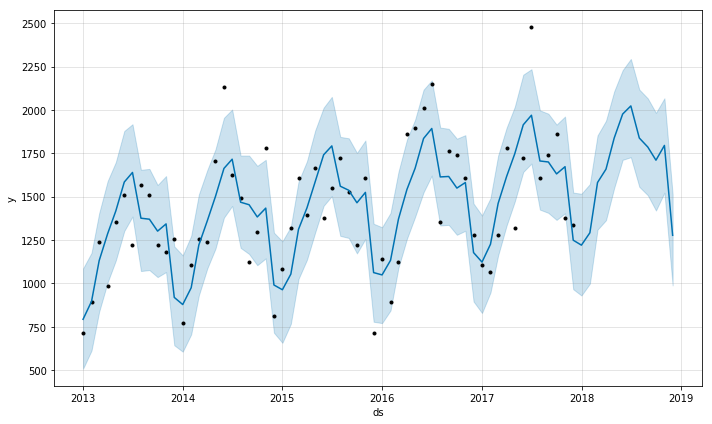

In [17]:
fig1 = m.plot(forecast)

- We can break this down a bit further by calling the plot_components() method to inspect the forecast components.

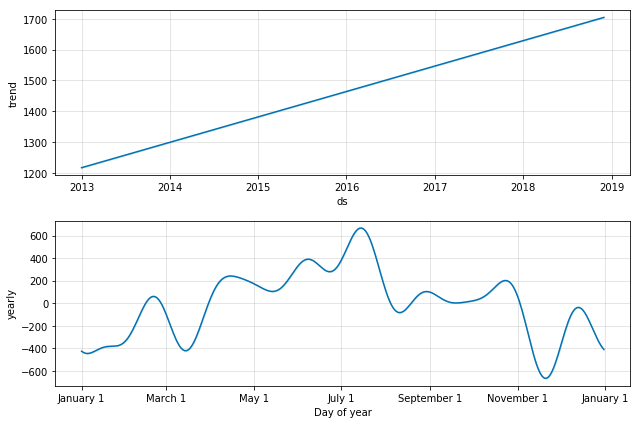

In [18]:
fig2 = m.plot_components(forecast)

## Evaluate
- Evaluate the forecast using Prophet’s cross validation procedure.


- Use the cross_validation() function on the model and specify the forecast horizon with the horizon parameter.
- Next, call performance_metrics() to get a table with various prediction performance metrics.

In [74]:
from fbprophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(m, horizon = '365 days')

# from fbprophet.diagnostics import cross_validation, performance_metrics
# # cross_validation(m, initial = 730, period = 180, horizon = 365, units = 'days')
# df_cv = cross_validation(m, horizon='90 days')

INFO:fbprophet:Making 2 forecasts with cutoffs between 2016-06-01 12:00:00 and 2016-12-01 00:00:00


In [76]:
df_p = performance_metrics(df_cv)
df_p.head(100)

,horizon,mse,rmse,mae,mape,coverage
12,31 days 00:00:00,160370.497587,400.462854,316.691008,0.163148,0.5
1,60 days 12:00:00,75427.783165,274.641190,226.665962,0.173280,0.5
13,62 days 00:00:00,102860.428447,320.718613,313.337690,0.255857,0.5
14,90 days 00:00:00,70029.377527,264.630644,263.946340,0.225738,0.5
2,91 days 12:00:00,63480.713056,251.953792,249.755585,0.172184,0.5
15,121 days 00:00:00,35179.355663,187.561605,184.866915,0.104461,1.0
3,121 days 12:00:00,70759.589256,266.006747,248.387816,0.141599,0.5
16,151 days 00:00:00,241235.388252,491.157193,473.629254,0.327871,0.0
4,152 days 12:00:00,182551.870725,427.260893,314.928213,0.237423,0.5
17,182 days 00:00:00,46680.626844,216.056999,165.306273,0.096488,0.5


- We can also plot the mean absolute percent error (MAPE) over the forecast horizon to determine how trustworthy our forecast is.
- Here, we use a percentage error instead of the mean squared error (MSE) simply because it is easier to interpret.

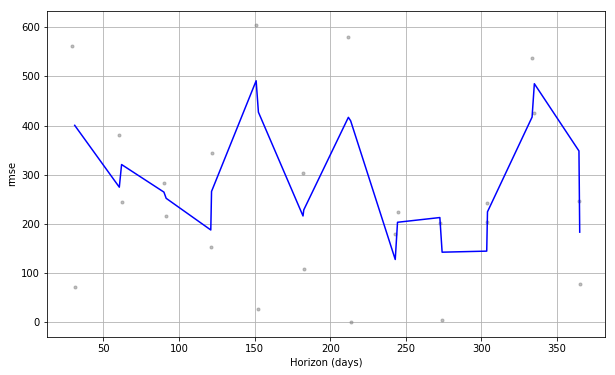

In [77]:
from fbprophet.plot import plot_cross_validation_metric, plot_forecast_component
fig3 = plot_cross_validation_metric(df_cv,metric='rmse')

# from fbprophet.plot import plot_cross_validation_metric, plot_forecast_component
# fig3 = plot_cross_validation_metric(df_cv, metric='rmse')

### Return a data frame with the month, storeid, yhat, and the confidence intervals (yhat lower, yhat upper)

### Plot the 2018 monthly sales predictions for each store to compare predicted performance. (e.g. line chart where each line represents store id (color), x is the month, y is sales)